In [1]:
import ReplayBuffer

In [2]:
import matplotlib.pyplot as plt
import matplotlib
import joblib
import os
import numpy as np
from scipy import interpolate

In [3]:
max_error = .5
err_treshold = .10

In [4]:
cmap = matplotlib.cm.jet
norm = matplotlib.colors.Normalize(vmin=0, vmax=max_error)

cmap2 = matplotlib.cm.cool
norm2 = matplotlib.colors.Normalize(vmin=0, vmax=err_treshold)

# Feasible region calulcation

In [5]:
def calc_feasible_region(model_name, cmap, norm, cmap2, norm2):
    # global feasible_region, target_points
    rb = joblib.load(
        f'../runs/test/model_{model_name}/ReplayBuffer_test.joblib')

    model_name = model_name if not str(model_name).isnumeric() else model_name+1
    e = rb.mem_size-1
    com0_points = rb.state[:e][:, :3]
    target_points = rb.state[:e][:, 3:]
    reached_points = rb.next_state[:e][:, :3]
    target_error = np.linalg.norm(target_points - reached_points, axis=1)

    # Draw target, reached merge
    fig = fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    ax.set_xlim(-.65, .65)
    ax.set_ylim(-.65, .65)
    ax.set_zlim(0, .5)

    ax.view_init(45, 45)

    ax.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2],
               color="blue", alpha=0.6, edgecolors="black", linewidths=0.2, label="target CoM")

    ax.scatter(reached_points[:, 0], reached_points[:, 1], reached_points[:, 2],
               color="red", alpha=0.6, edgecolors="black", linewidths=0.2, label="reached CoM")

    ax.legend()
    fig.savefig(os.path.join('plots3', f'{model_name}_merge.jpg'), dpi=300)
    plt.show()

    # Draw target with target_error cbar
    fig = fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')

    ax.set_xlim(-.65, .65)
    ax.set_ylim(-.65, .65)
    ax.set_zlim(0, .5)

    ax.view_init(45, 45)
    test_distance = ax.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2],
                               c=target_error, alpha=0.7, edgecolors="black", linewidths=0.2,
                               cmap=cmap, norm=norm, label="target CoM")
    cbar = plt.colorbar(test_distance, shrink=0.5)
    cbar.set_label("target error [m]")
    ax.legend()
    fig.savefig(os.path.join('plots3', f'{model_name}_complete.jpg'), dpi=300)
    plt.show()

    # Filter jump with .1 m error
    reachable_idx = target_points[:,2] < 0.4 # real reachable region
    
    idx = target_error <= err_treshold
    err_filter = target_error[idx]
    feasible_region = target_points[idx, :]
    perc_of_point = len(err_filter)/target_points[reachable_idx, :].shape[0]
    
    

    fig = fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-.65, .65)
    ax.set_ylim(-.65, .65)
    ax.set_zlim(0, .5)
    ax.view_init(45, 45)
    feasible_filtered = ax.scatter(feasible_region[:, 0], feasible_region[:, 1], feasible_region[:, 2],
                                    c=err_filter, alpha=0.7, edgecolors="black", linewidths=0.2,
                                    cmap=cmap2, norm=norm2, label="target CoM")
    cbar = plt.colorbar(feasible_filtered, shrink=0.5)
    cbar.set_label("target error [m]")
    ax.legend()
    fig.savefig(os.path.join('plots3', f'{model_name}_filtered.jpg'), dpi=300)
    plt.show()
    
    # top
    fig = fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-.65, .65)
    ax.set_ylim(-.65, .65)
    ax.set_zlim(0, .5)
    ax.view_init(azim=0,elev=90)
    feasible_filtered = ax.scatter(feasible_region[:, 0], feasible_region[:, 1], feasible_region[:, 2],
                                    c=err_filter, alpha=0.7, edgecolors="black", linewidths=0.2,
                                    cmap=cmap2, norm=norm2, label="target CoM")
    cbar = plt.colorbar(feasible_filtered, shrink=0.5)
    cbar.set_label("target error [m]")
    ax.legend()
    fig.savefig(os.path.join('plots3', f'{model_name}_filtered_top.jpg'), dpi=300)
    plt.show()
    
    
    # side

    fig = fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim(-.65, .65)
    ax.set_ylim(-.65, .65)
    ax.set_zlim(0, .5)
    ax.view_init(0, 90)
    feasible_filtered = ax.scatter(feasible_region[:, 0], feasible_region[:, 1], feasible_region[:, 2],
                                    c=err_filter, alpha=0.7, edgecolors="black", linewidths=0.2,
                                    cmap=cmap2, norm=norm2, label="target CoM")
    cbar = plt.colorbar(feasible_filtered, shrink=0.5)
    cbar.set_label("target error [m]")
    ax.legend()
    fig.savefig(os.path.join('plots3', f'{model_name}_filtered_side.jpg'), dpi=300)
    plt.show()

    return perc_of_point


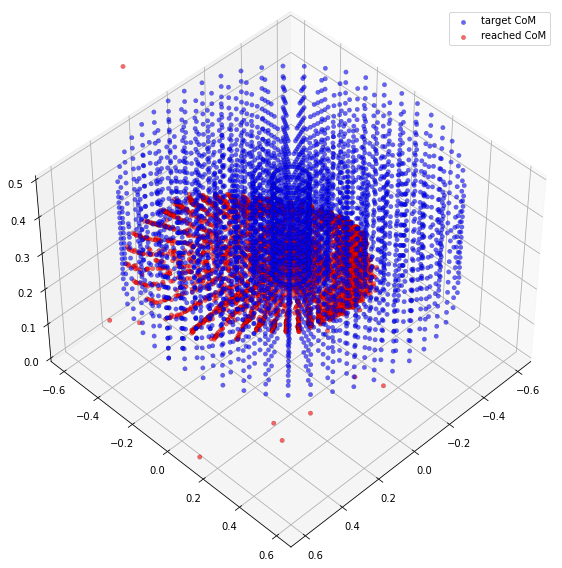

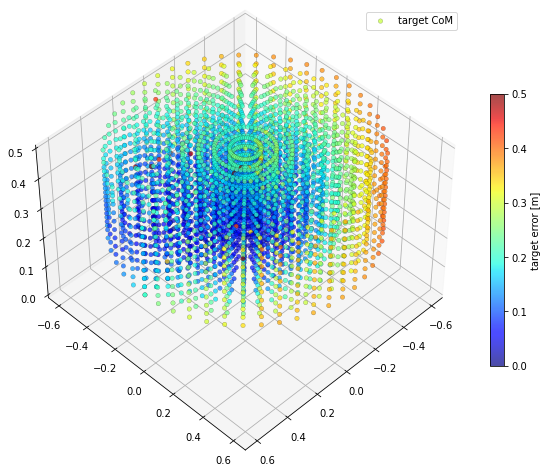

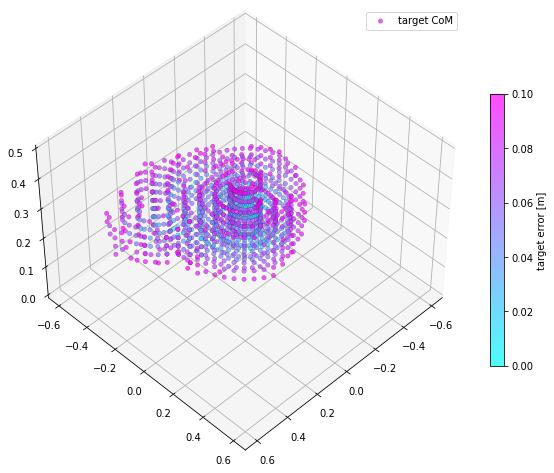

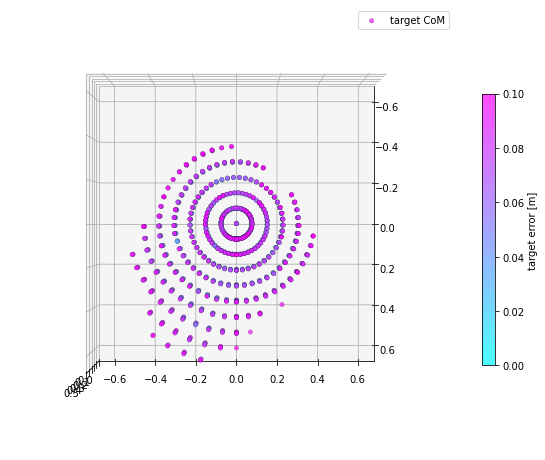

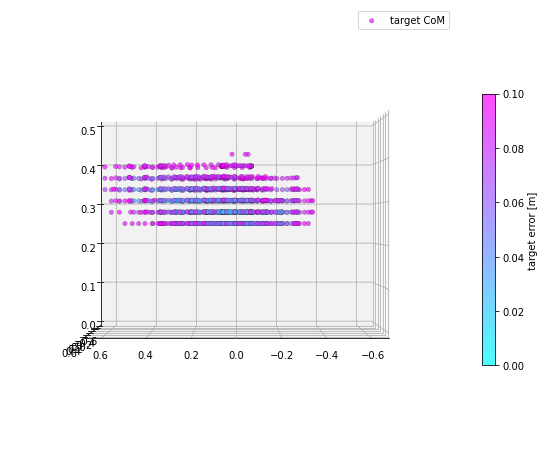

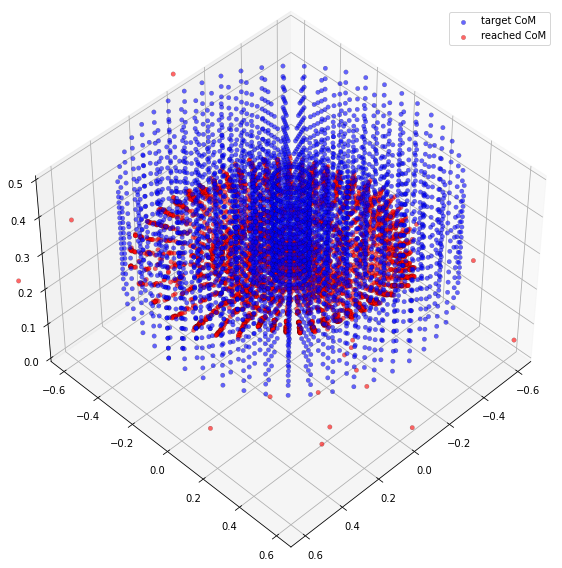

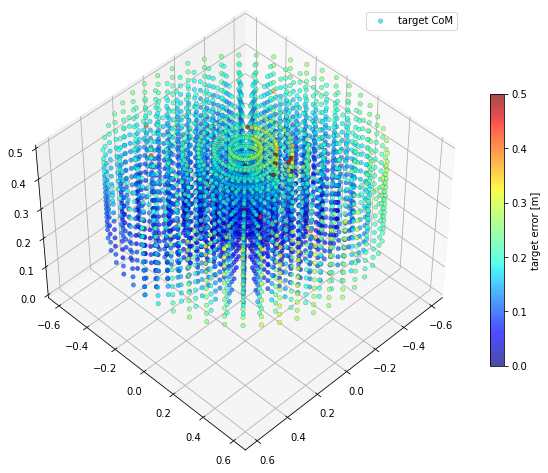

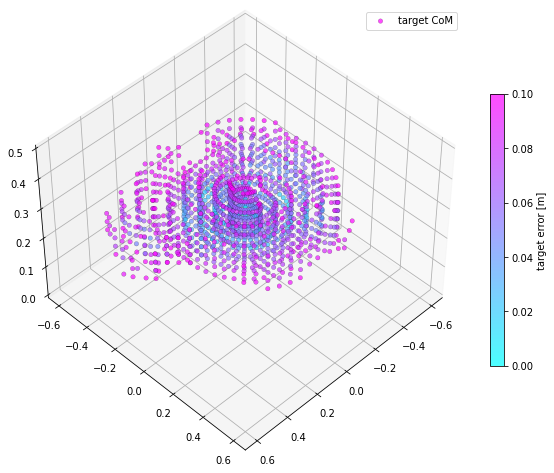

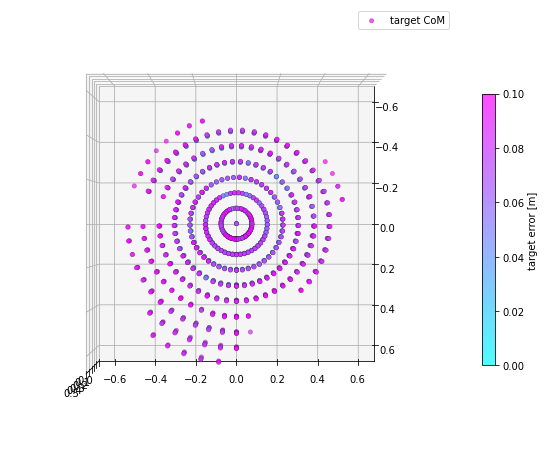

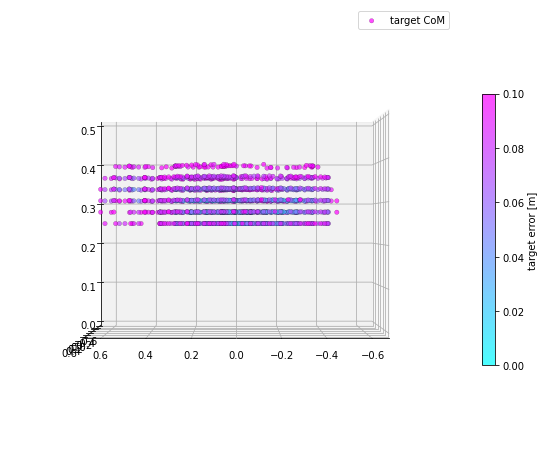

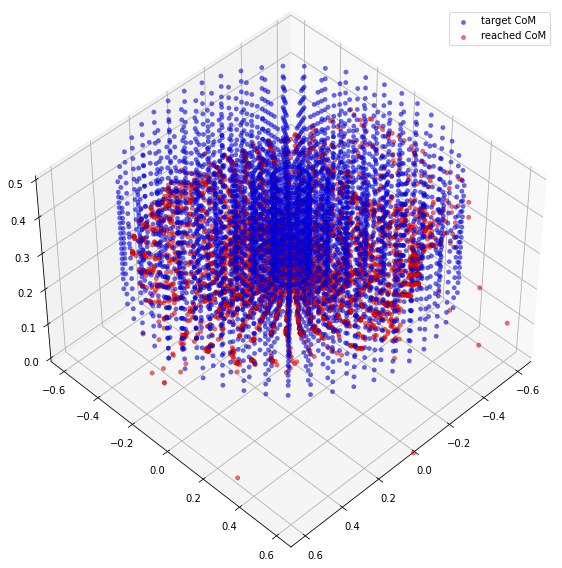

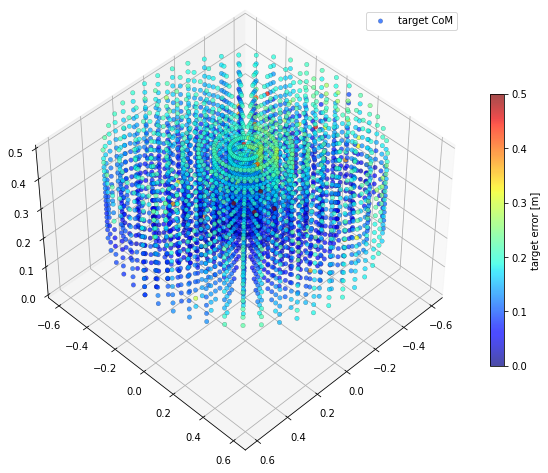

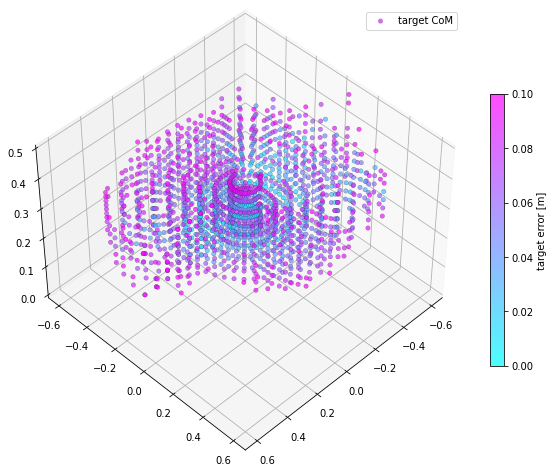

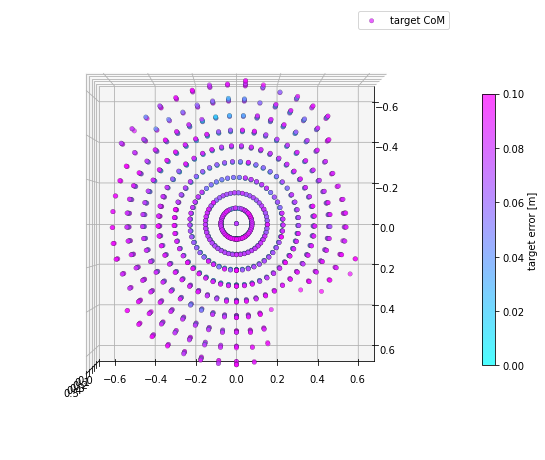

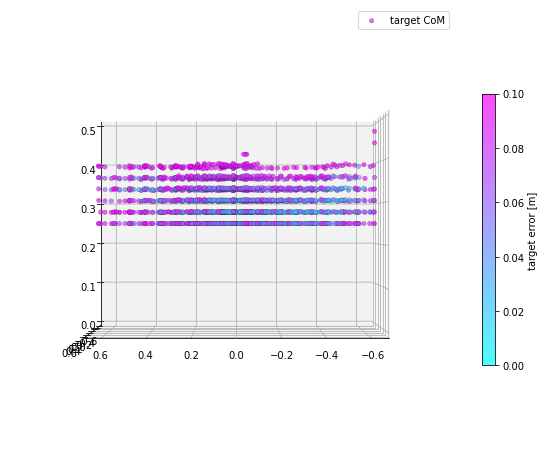

In [6]:
test = [4999,9999,24999]
perc_point = [calc_feasible_region(epoch,cmap,norm,cmap2,norm2) for epoch in test]

Text(0, 0.5, '% of jumps with error <= 0.1 m')

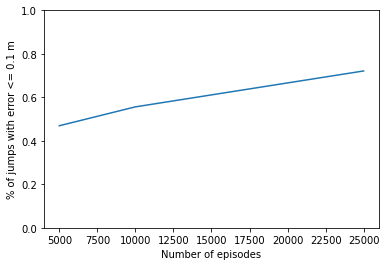

In [7]:
plt.ylim(0,1)
plt.plot(test,perc_point)
plt.xlabel('Number of episodes')
plt.ylabel('% of jumps with error <= 0.1 m')

In [8]:
perc_point

[0.4693274205469327, 0.5561714708056171, 0.721359940872136]